# Case Santander Customer Satisfaction

Este projeto utiliza como base o dataset da competição Santander Customer Satisfaction, disponibilizada no Kaggle em 2016. O objetivo original da competição é identificar clientes insatisfeitos a partir de centenas de variáveis anonimizadas, permitindo que o banco possa agir de forma antecipada para reduzir churn. A métrica oficial de avaliação é a área sob a curva ROC (ROC_AUC), calculada a partir da probabilidade prevista para a variável TARGET, que indica se o cliente está satisfeito ou não.

A competição pode ser encontrada em:
https://www.kaggle.com/competitions/santander-customer-satisfaction

Objetivos:
O objetivo deste projeto é tratar o problema como uma tarefa de classificação binária, buscando identificar clientes insatisfeitos a partir das variáveis disponíveis. A partir das previsões do modelo, é construído um cenário hipotético de negócio, no qual se simula um custo associado a ações de retenção e à perda de clientes, com o intuito de maximizar o lucro esperado por cliente.
A partir desse ponto, desdobramentos e análises adicionais são possíveis, conforme a evolução do modelo e das hipóteses consideradas.

# Instalações & Importações

In [117]:
# Instalação de Bibliotecas (Já estão presentes no requirements.txt)
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install scipy
# !pip install factor_analyzer
# !pip install matplotlib
# !pip install catboost
# !pip install graphviz
# !pip install plotly

In [118]:
# Bibliotecas Basicas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

## Validação Cruzada e Pipeline
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

## Métricas de Validação
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

## Pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Cluster Hierárquico
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# Modelos
import xgboost
from xgboost import XGBClassifier
from  sklearn.linear_model import LogisticRegression
from  sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Funções

## Funções de Relatório e Pré-Processamento

In [119]:
def calcula_prevalencia(y_actual):
    '''
    Calcula e exibe a prevalência da classe positiva em um conjunto de rótulos reais.
    '''
    print(f'Prevalência da classe não nula (1): {sum(y_actual) * 100/ len(y_actual):.3f}%')


def calcula_valores_validos(df):
    '''
    Calcula e exibe a porcentagem de valores nulos ou faltantes em cada coluna do DataFrame apenas se existirem.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    valores_exibidos = 0
    for col in df.columns:
        soma_nulos = sum(df[col].isnull() | df[col].isna())
        if soma_nulos > 0 :
            print(f'Valores Nulos em {col}: {soma_nulos * 100/ len(df[col]):.3f}%')
            valores_exibidos += 1
    if valores_exibidos == 0:
        print('Nenhum valor nulo ou faltante encontrado no DataFrame.')


def verifica_balanceamento(df, coluna_alvo):
    '''
    Verifica o balanceamento das classes em uma coluna alvo de um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    coluna_alvo (str): O nome da coluna alvo que contém as classes.
    '''
    contagem_classes = df[coluna_alvo].value_counts()
    proporcao_classes = df[coluna_alvo].value_counts(normalize=True) * 100
    balanceamento = pd.DataFrame({'Contagem': contagem_classes, 'Proporção (%)': np.round(proporcao_classes, 2)})
    print(balanceamento)


def verifica_coluna_constante(df):
    '''
    Verifica se há colunas constantes (com o mesmo valor em todas as linhas) em um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    colunas_constantes = [col for col in df.columns if df[col].nunique() == 1]
    if colunas_constantes:
        print(f'Colunas constantes encontradas: {colunas_constantes}')
    else:
        print('Nenhuma coluna constante encontrada.')


def relatorio(df: pd.DataFrame) -> None:
    """Gera um breve relatório exploratório do DataFrame"""


    print("=" * 70)
    print(f"Número de Colunas: {df.shape[1]:,}")
    print(f"Número de Linhas: {df.shape[0]:,}")
    print("=" * 70)

    # Linhas duplicadas (ignorando ID)
    dup_mask = df.drop(columns=['ID','TARGET'], errors='ignore').duplicated(keep='first')
    print(f"Número de Linhas Duplicadas: {dup_mask.sum():,}")

    # Colunas constantes
    const_cols = [
        c for c in df.columns
        if c != 'ID' and df[c].nunique(dropna=False) == 1
    ]
    print(f"Número de Colunas Constantes: {len(const_cols):,}")

    # Colunas idênticas (Aprofundar o Conceitual)
    col_hashes = df.apply(lambda col: hash(tuple(col)), axis=0)
    num_identicas = col_hashes.duplicated().sum()
    print(f"Número de Colunas Idênticas: {num_identicas:,}")

    print("=" * 70)

    # Valores nulos
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0].sort_values(ascending=False)
    print(f"Colunas com Valores Nulos: {len(nulls):,}")

    print("=" * 70)

    # Distribuição da variável TARGET
    if 'TARGET' in df.columns:
        target_0 = (df['TARGET'] == 0).sum()
        target_1 = (df['TARGET'] == 1).sum()
        total = len(df)

        print(f"TARGET = 0 (Insatisfeitos): {target_0:,} ({target_0 / total:.1%})")
        print(f"TARGET = 1 (Satisfeitos): {target_1:,} ({target_1 / total:.1%})")
        print(f"Total de clientes: {total:,}")
    else:
        print("Coluna TARGET não encontrada.")

    print("=" * 70)


## Funções de Cross-Validation Personalizadas

In [120]:
def threshold_otimizado_f1(y_true, y_prob, n_thresholds=100):
    """
    Encontra o threshold que maximiza o F1-score.
    """
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    best_f1 = -1
    best_threshold = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


def validacao_cruzada_f1(
    modelo,
    X,
    y,
    metric,
    oversampler=None,
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada com threshold otimizado para F1-score.
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    scores = []
    thresholds_otimos = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Probabilidade da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # Threshold ótimo + F1
        best_threshold, best_f1 = threshold_otimizado_f1(y_test, y_prob)

        scores.append(best_f1)
        thresholds_otimos.append(best_threshold)

        print(
            f"Fold {fold}: "
            f"F1 = {best_f1:.4f} | "
            f"Threshold ótimo = {best_threshold:.2f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"F1 médio: {np.mean(scores):.4f}")
    print(f"Desvio padrão F1: {np.std(scores):.4f}")
    print(f"Threshold médio: {np.mean(thresholds_otimos):.2f}")

    return {
        "f1_scores": scores,
        "thresholds": thresholds_otimos
    }


def validacao_cruzada_prauc(
    modelo,
    X,
    y,
    oversampler=None,
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada usando PR-AUC (Average Precision).
    Avalia ranking, não threshold.
    """

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    pr_auc_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Score contínuo da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # PR-AUC (Average Precision)
        pr_auc = average_precision_score(y_test, y_prob)
        pr_auc_scores.append(pr_auc)

        print(
            f"Fold {fold}: "
            f"PR-AUC = {pr_auc:.4f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"PR-AUC médio: {np.mean(pr_auc_scores):.4f}")
    print(f"Desvio padrão PR-AUC: {np.std(pr_auc_scores):.4f}")

    return {
        "pr_auc_scores": pr_auc_scores
    }



## Funções de Pipeline

In [121]:
class PipeSteps(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

# Importação de Arquivos

In [122]:
df_train = pd.read_csv("data/processed/train.csv")
df_test = pd.read_csv("data/processed/test.csv")

# Análise Exploratória

In [123]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [124]:
df_test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [125]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


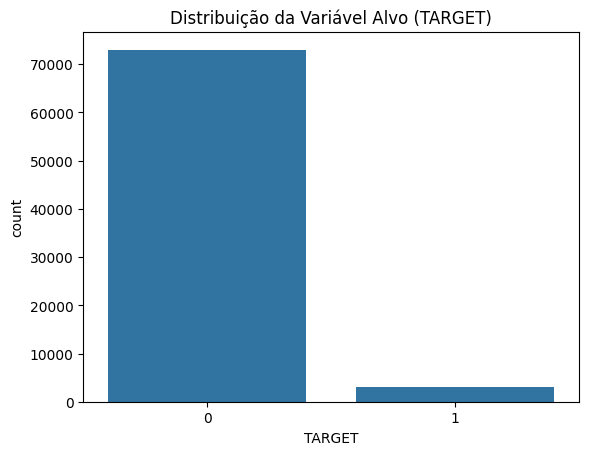

In [126]:
sns.countplot(x='TARGET', data=df_train)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.show()

In [127]:
verifica_balanceamento(df_train,'TARGET')
calcula_valores_validos(df_train)
verifica_coluna_constante(df_train)

        Contagem  Proporção (%)
TARGET                         
0          73012          96.04
1           3008           3.96
Nenhum valor nulo ou faltante encontrado no DataFrame.
Colunas constantes encontradas: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [128]:
relatorio(df_train)

Número de Colunas: 371
Número de Linhas: 76,020
Número de Linhas Duplicadas: 4,940
Número de Colunas Constantes: 34
Número de Colunas Idênticas: 62
Colunas com Valores Nulos: 0
TARGET = 0 (Insatisfeitos): 73,012 (96.0%)
TARGET = 1 (Satisfeitos): 3,008 (4.0%)
Total de clientes: 76,020


In [129]:
# Colunas Categóricas
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

print('Colunas categóricas:', list(cat_cols))
print('Qtd:', len(cat_cols))

# Possíveis colunas categóricas numéricas ou com Baixo Número valores únicos
candidate_cat = [
    col for col in df_train.select_dtypes(include=['int', 'int64', 'float']).columns
    if df_train[col].nunique() <= 10
]

# Serão usadas para análises futuras
print('Possíveis categóricas numéricas:', len(candidate_cat))

Colunas categóricas: []
Qtd: 0
Possíveis categóricas numéricas: 239


# Separação em Treino e Validação

In [130]:
# Lista dos atributos que serão utilizados como entrada (Diferentes da classe alvo, ID e não constantes)
atributos = [x for x in df_train.columns if
             (df_train[f'{x}'].nunique() > 1
              and x not in ('Class', 'TARGET', 'ID'))]

In [131]:
X = df_train[atributos]
y = df_train['TARGET']
X_treino, X_teste, y_treino, y_teste = train_test_split(
                                                    X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.30,
                                                    random_state = 42)

In [132]:
calcula_prevalencia(y_treino)

Prevalência da classe não nula (1): 3.958%


In [133]:
calcula_prevalencia(y_teste)

Prevalência da classe não nula (1): 3.955%


# Modelos Base

In [134]:
'ID' in atributos

False

In [135]:
pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(atributos))
])

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessing', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7913
Desvio ROC_AUC: 0.0097
PR_AUC médio : 0.1420
Desvio PR_AUC: 0.0098
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8188
Desvio ROC_AUC: 0.0099
PR_AUC médio : 0.1713
Desvio PR_AUC: 0.0158
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7582
Desvio ROC_AUC: 0.0124
PR_AUC médio : 0.1116
Desvio PR_AUC: 0.0050
--------------------------------------------------


# Seleção de Features

## Análise de Corelação entre as Variáveis

In [136]:
# Cálculo da matriz de correlação
corr_matrix = X.corr()

# Mantém apenas correlações fortes (maior que 0.5 ou menor que -0.5)
# excluindo a diagonal principal
strong_corr = corr_matrix.where(
    (np.abs(corr_matrix) > 0.5) & (np.abs(corr_matrix) < 1.0)
)

# Remoção de linhas e colunas que são completamente NaN
strong_corr_clean = (
    strong_corr
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
)

# Máscara para ocultar a parte superior da matriz de correlação
mask_upper = np.triu(
    np.ones_like(strong_corr_clean, dtype=bool),
    k=1
)

# Aplicação da máscara
strong_corr_final = strong_corr_clean.mask(mask_upper)

# Conversão para DataFrame longo
corr_df = (
    strong_corr_final
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

# Filtragem para correlações absolutas maiores que 0.9
corr_df_90 = (
    strong_corr_final[strong_corr_final.abs() > 0.9]
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

print(
    'N de correlações |corr| > 0.99 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.99])
)

print(
    'N de correlações |corr| > 0.9 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.9])
)

print(
    'N de correlações |corr| > 0.8 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.8])
)

N de correlações |corr| > 0.99 = 86
N de correlações |corr| > 0.9 = 284
N de correlações |corr| > 0.8 = 483


In [137]:
contador = 0
sus_col = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9:', len(sus_col))
print('') # Melhora a legibilidade

# Filtra apenas as correlações absolutas maiores que 0.9 entre colunas categóricas suspeitas
corr_df_90_sus_cat = corr_df_90[(corr_df_90['feature_1'].isin(sus_col))
                                | (corr_df_90['feature_2'].isin(sus_col))]


contador = 0
sus_col_inter = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col_inter.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si:', len(sus_col_inter))

Colunas categóricas suspeitas que possuem alguma correlação > 0.9: 140

Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si: 140


Muitas Colunas categóricas suspeitas e que possuem alguma forte correlçao com outra (n=140) sendo que todas elas possuem essa forte correlação entre si

### Agrupamento das Features via Sperman

In [138]:
# Módulo das Correlações
corr = X.corr(method='spearman').abs()

# Transformar em Distância
dist = 1 - corr

dist_condensed = squareform(dist.values)

Z = linkage(dist_condensed, method='average')

# Corte do dendrograma para formar clusters
cutoff = 0.1
clusters = fcluster(Z, t=cutoff, criterion='distance')

# Dicionário com os Cluster
cluster_map = (
    pd.DataFrame({
        'feature': corr.index,
        'cluster': clusters
    })
    .sort_values(by='cluster')
    .reset_index(drop=True)
)

# Contagem de variáveis por cluster
counts = cluster_map['cluster'].value_counts()

# Clusters com mais de uma variável
clusters_gt1 = counts[counts > 1].sort_values(ascending=False)

# Exibição dos resultados
print('Total de clusters formados com > 1 variáveis:', len(clusters_gt1))
# print('Lista')
# for cluster, count in clusters_gt1.items():
#     print(f'Cluster = {cluster} | variáveis (n) = {count}')

# Selecionar uma variável representativa de cada cluster
selected = []
for cluster_id in np.unique(clusters):

    features = cluster_map.query(
        "cluster == @cluster_id"
    )["feature"]

    X_cluster = X_treino[features]

    mi = mutual_info_classif(
        X_cluster,
        y_treino,
        discrete_features="auto",
        random_state=42
    )

    mi_series = pd.Series(mi, index=features)
    best = mi_series.idxmax()

    selected.append(best)


Total de clusters formados com > 1 variáveis: 75


In [139]:
import math

def print_cols(items, n_cols=3):
    rows = math.ceil(len(items) / n_cols)
    cols = [items[i*rows:(i+1)*rows] for i in range(n_cols)]

    for row in zip(*[c + ['']*(rows-len(c)) for c in cols]):
        print('  '.join(f'{x:<40}' for x in row if x))

print('Listagem\n')

for cluster, count in clusters_gt1.items():
    if count > 3:
        vars_ = cluster_map.loc[
            cluster_map["cluster"] == cluster, "feature"
        ].tolist()

        print(f'Cluster = {cluster} | variáveis (n) = {count}')
        print_cols(vars_, n_cols=3)
        print('-' * 80)


Listagem

Cluster = 68 | variáveis (n) = 12
ind_var26_0                               num_var25_0                               saldo_var26                             
ind_var25_cte                             ind_var25_0                               saldo_var25                             
ind_var26_cte                             ind_var25                                 num_var25                               
num_var26_0                               ind_var26                                 num_var26                               
--------------------------------------------------------------------------------
Cluster = 8 | variáveis (n) = 9
saldo_medio_var13_medio_ult1              ind_var13_medio_0                         saldo_var13_medio                       
saldo_medio_var13_medio_ult3              num_meses_var13_medio_ult3                num_var13_medio                         
ind_var13_medio                           saldo_medio_var13_medio_hace2             num_var13

In [140]:
'ID' in selected

False

In [141]:
# Segurança para remover 'ID' se estiver na lista selected
if 'ID' in selected:
    selected.remove('ID')

# Modelos c/ Seleção de Features

In [142]:
# Criação do pipeline de pré-processamento com as colunas selecionadas
pipe_prepropcessamento = Pipeline([('feature_selection', SelecionaColunas(selected)),
                                       ('standard_scaling', PadronizaDados(selected))])
# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
}


for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessamento', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7918
Desvio ROC_AUC: 0.0092
PR_AUC médio : 0.1429
Desvio PR_AUC: 0.0110
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8197
Desvio ROC_AUC: 0.0093
PR_AUC médio : 0.1683
Desvio PR_AUC: 0.0158
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7578
Desvio ROC_AUC: 0.0129
PR_AUC médio : 0.1118
Desvio PR_AUC: 0.0049
--------------------------------------------------


# PCA

In [143]:
'ID' in X_treino

False

In [ ]:
# Core do PCA
scaler = StandardScaler()

# Teste e Treino
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled  = scaler.transform(X_teste)

pca = PCA()
X_train_pca = pca.fit_transform(X_treino_scaled)

# Variância Acumlada
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# Análise Eigenvalues (Critério de Kaiser e Análise de Cotovelo)
eigenvalues = pca.explained_variance_

eigenvalues_kaiser = eigenvalues[eigenvalues > 1]
n_componentes_kaiser = len(eigenvalues_kaiser)

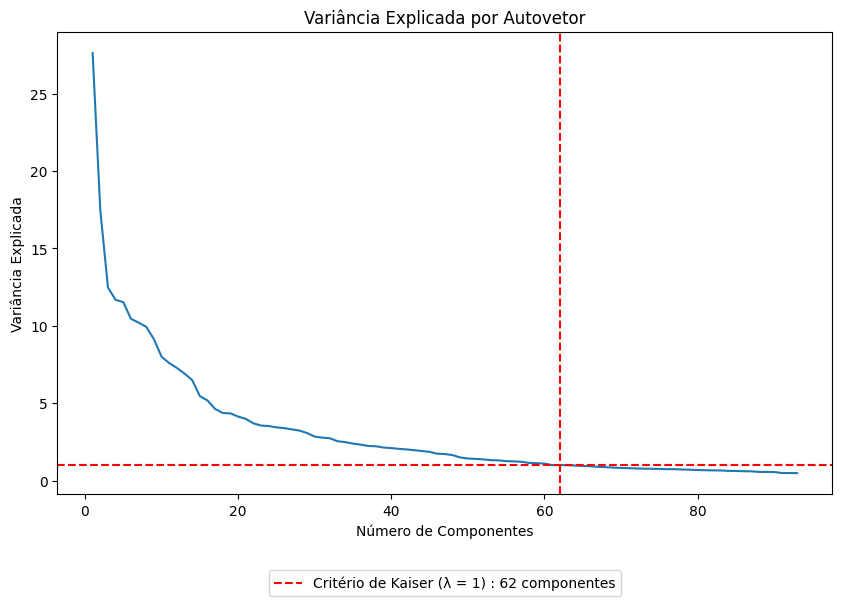

Número de componentes pelo critério de Kaiser: 62


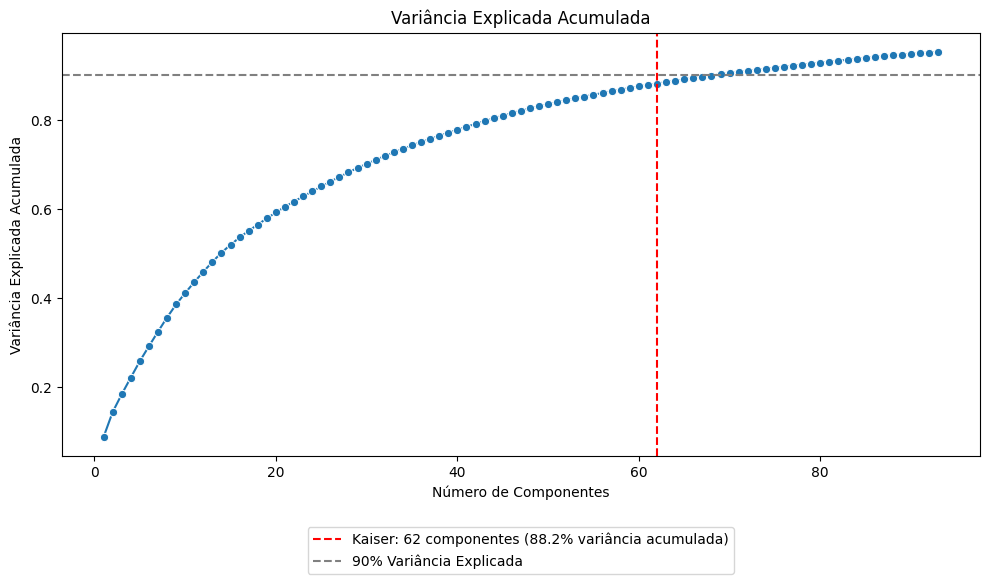

In [ ]:
print(f"Número de componentes pelo critério de Kaiser: {n_componentes_kaiser}")

# Plotar até o dobro do número de componentes indicado pelo critério de Kaiser
n_componentes_kaiser_plot = int(n_componentes_kaiser * 1.5)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=eigenvalues[0:n_componentes_kaiser_plot])

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=f"Critério de Kaiser (λ = 1) : {n_componentes_kaiser} componentes"
)

plt.axhline(
    y=1,
    color="red",
    linestyle="--"
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)
plt.title("Variância Explicada por Autovetor")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada")
plt.show()

plt.figure(figsize=(10, 6))

sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=cum_var_exp[:n_componentes_kaiser_plot],
    marker='o'
)

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=(
        f"Kaiser: {n_componentes_kaiser} componentes "
        f"({cum_var_exp[n_componentes_kaiser - 1]:.1%} variância acumulada)"
    )
)

# Linha de referência (ex: 90%)
plt.axhline(
    y=0.9,
    color='gray',
    linestyle='--',
    label='90% Variância Explicada'
)

plt.title("Variância Explicada Acumulada")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)

plt.tight_layout()
plt.show()

Como parece não haver um "cotovelo" bem definido, vamos usar o critério de kaiser matendo aproxidamente 87,2% da variância acumulada com 62 PC´s

# Modelos com PCA

In [317]:
# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_componentes_kaiser)),
    ('classifier', modelo)
    ])


    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X_treino,
        y_treino,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )


    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)

Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7798
Desvio ROC_AUC: 0.0092
PR_AUC médio : 0.1360
Desvio PR_AUC: 0.0052
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.7697
Desvio ROC_AUC: 0.0139
PR_AUC médio : 0.1427
Desvio PR_AUC: 0.0104
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7214
Desvio ROC_AUC: 0.0168
PR_AUC médio : 0.0997
Desvio PR_AUC: 0.0083
--------------------------------------------------


# Resultados da Validação Cruzada — Comparação de Modelos

## Baseline

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7913 ± 0.0097          | 0.1420 ± 0.0098          |
| XGBoost             | 0.8188 ± 0.0099          | 0.1713 ± 0.0158          |
| Random Forest       | 0.7582 ± 0.0124          | 0.1116 ± 0.0050          |


## Seleção de Features (Agrupamento)

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7918 ± 0.0092          | 0.1429 ± 0.0110          |
| XGBoost             | 0.8197 ± 0.0093          | 0.1683 ± 0.0158          |
| Random Forest       | 0.7578 ± 0.0129          | 0.1118 ± 0.0049          |

## PCA

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7798 ± 0.0092          | 0.1360 ± 0.0052          |
| XGBoost             | 0.7697 ± 0.0139          | 0.1427 ± 0.0104          |
| Random Forest       | 0.7214 ± 0.0168          | 0.0997 ± 0.0083          |

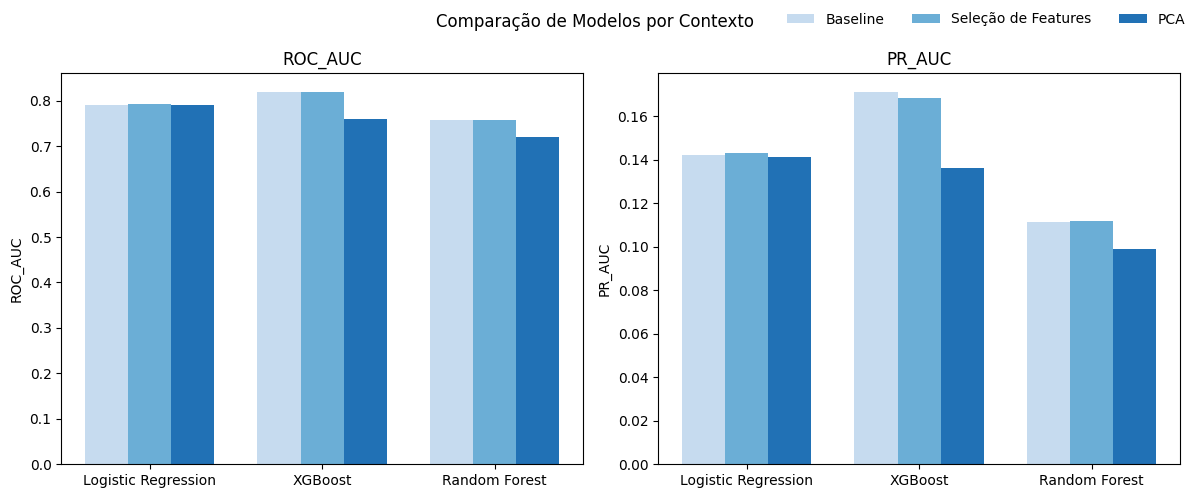

In [ ]:
# Dados / Configurações Bases
modelos = ["Logistic Regression", "XGBoost", "Random Forest"]

roc_baseline = [0.7913, 0.8188, 0.7582]
roc_sel = [0.7918, 0.8197, 0.7578]
roc_pca = [0.7798, 0.7697, 0.7214]

pr_baseline = [0.1420, 0.1713, 0.1116]
pr_sel = [0.1429, 0.1683, 0.1118]
pr_pca = [0.1360, 0.1427, 0.0997]

x = np.arange(len(modelos))
width = 0.25

# figura com dois subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True)

# ROC_AUC
## Colunas
axes[0].bar(x - width, roc_baseline, width, label="Baseline", color="#c6dbef")
axes[0].bar(x,           roc_sel,      width, label="Seleção de Features", color="#6baed6")
axes[0].bar(x + width, roc_pca,     width, label="PCA", color="#2171b5")

## Labels e Títulos
axes[0].set_ylabel("ROC_AUC")
axes[0].set_title("ROC_AUC")
axes[0].set_xticks(x)
axes[0].set_xticklabels(modelos)

# PR_AUC
## Colunas
axes[1].bar(x - width, pr_baseline, width, label="Baseline", color="#c6dbef")
axes[1].bar(x,           pr_sel,      width, label="Seleção de Features", color="#6baed6")
axes[1].bar(x + width, pr_pca,     width, label="PCA", color="#2171b5")

## Labels e Títulos
axes[1].set_ylabel("PR_AUC")
axes[1].set_title("PR_AUC")
axes[1].set_xticks(x)
axes[1].set_xticklabels(modelos)

# Legendas
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    frameon=False
)

fig.suptitle("Comparação de Modelos por Contexto", fontsize=12)
plt.tight_layout()
plt.show()


# Conclusão sobre a seleção de Modelo

Com base nos resultados obtidos nos experimentos de validação cruzada, o modelo a ser utilizado no restante do projeto será o *XGBoost*. Esse Modelo apresentou os melhores valores de *PR_AUC* e *ROC_AUC* em todos os experimentos, com exceção do cenário em que o PCA foi utilizado como etapa de pré-processamento. A queda de performance observada nesse caso pode estar relacionada ao fato de o XGBoost, por utilizar árvores de decisão combinadas por gradient boosting, apresentar melhor desempenho em cenários nos quais existe maior distinção entre as variáveis e maior significado semântico nos atributos originais. Ressalta-se, contudo, que essa hipótese ainda deve ser explorada de forma mais aprofundada.

A partir desse ponto, serão exploradas técnicas adicionais de pré-processo e tunning de hiperparâmetros com o objetivo de atingir o melhor desempenho possível do XGBoost na tarefa de classificação binária. O foco será maximizar a identificação da classe de clientes em churn, de modo a dar base ao planejamento de ações direcionadas a esses clientes, visando o estabelecimento de um cenário de maior ganho financeiro e manutenção da base de clientes.

# Evolução do Modelo Base

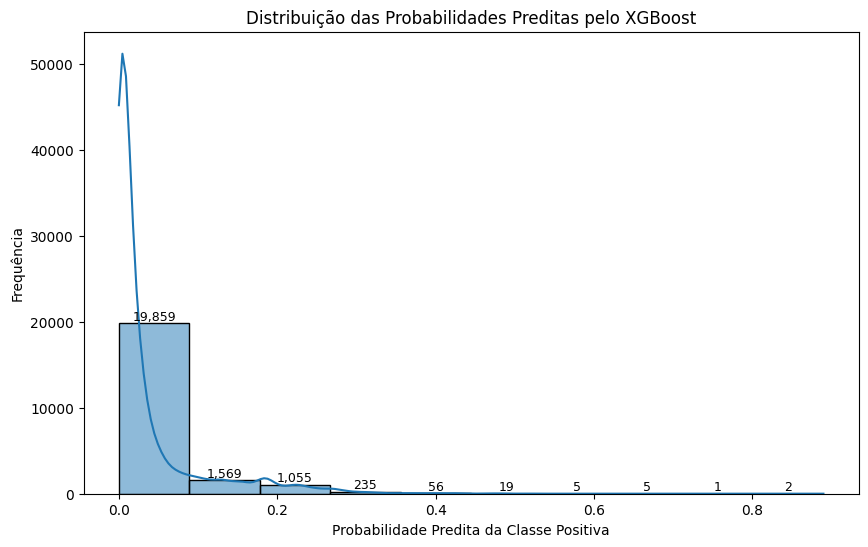

In [148]:
# Pré-processamento
pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(atributos))
])

# Pipeline completo
pipeline_xgb_base = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('XGBoost', XGBClassifier(
                        eval_metric='aucpr',
                        objective='binary:logistic',
                        random_state=42
    ))
])

# Treino do modelo
pipeline_xgb_base.fit(X_treino, y_treino)

# Predição de probabilidades da classe positiva
y_pred = pipeline_xgb_base.predict_proba(X_teste)[:, 1]

# Plot da distribuição das probabilidades preditas
plt.figure(figsize=(10, 6))
ax = sns.histplot(y_pred, bins=10, kde=True)
plt.title('Distribuição das Probabilidades Preditas pelo XGBoost')
plt.xlabel('Probabilidade Predita da Classe Positiva')
plt.ylabel('Frequência')

# Anotação dos valores em cada barra
for p in ax.patches:
    altura = int(p.get_height())
    if altura > 0:
        ax.annotate(
            f'{altura:,}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.show()

In [149]:
# Valores reais da variável alvo no conjunto de teste
y_teste.value_counts()

TARGET
0    21904
1      902
Name: count, dtype: int64

Número de atributos de entradas no modelo 335
Número de atributos usados pelo modelo 127
Diferença: 208
O modelo não usou todas as features disponíveis.


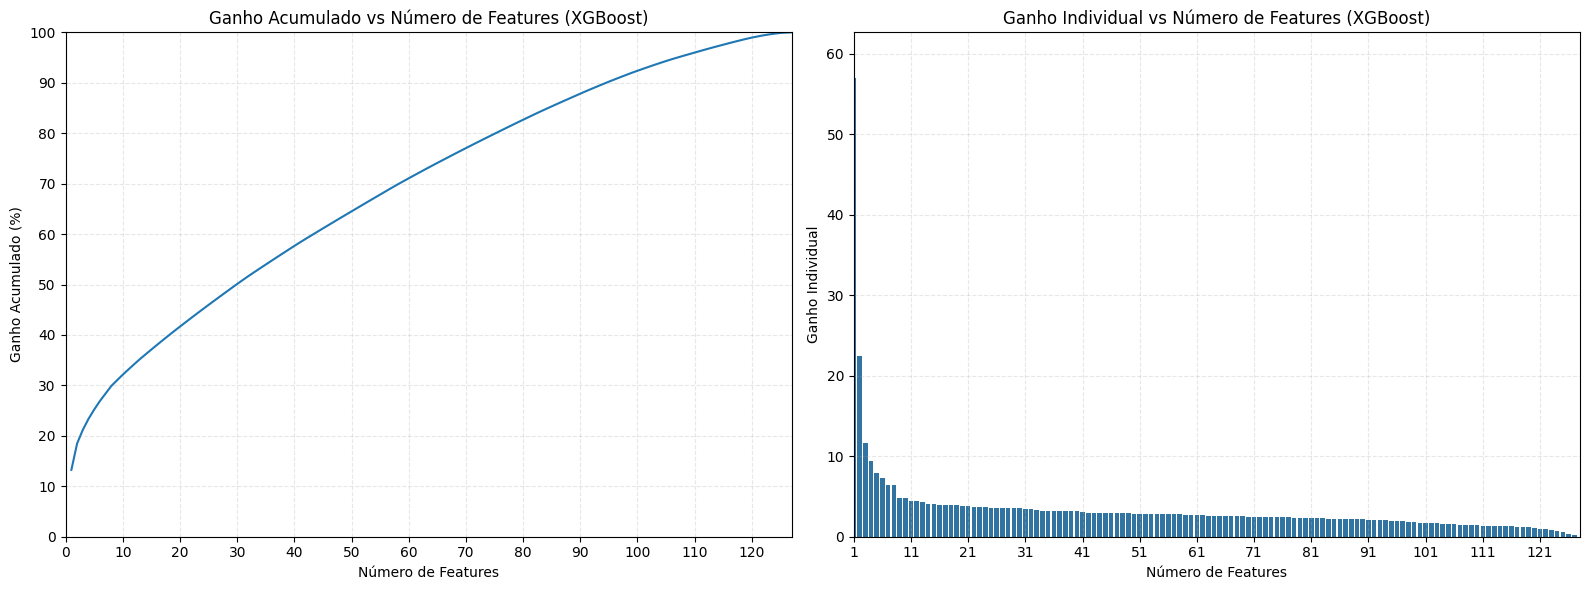

In [150]:
# Importancias
modelo = pipeline_xgb_base['XGBoost']

# Aumento médio da performance (mais informativo).
importancias_ganho = (
    modelo.get_booster()
    .get_score(importance_type='gain')
)

# Número de vezes que a feature foi usada em divisões.
importancias_peso = (
    modelo.get_booster()
    .get_score(importance_type='weight')
)

 # Cobertura média (número de observações afetadas).
importancias_cobertura = (
    modelo.get_booster()
    .get_score(importance_type='cover')
)


# DataFrame com diversas métricas de importância
importancias = pd.concat(
    [
    pd.Series(importancias_ganho, name='Ganho'),
    pd.Series(importancias_peso, name='Peso'),
    pd.Series(importancias_cobertura, name='Cobertura')], axis=1
).fillna(0)

print("="*60)
print("Número de atributos de entradas no modelo",len(atributos))
print("Número de atributos usados pelo modelo",len(importancias))
dif = len(atributos) - len(importancias)
print("="*60)
if dif != 0:
    print("Diferença:", dif)
    print("O modelo não usou todas as features disponíveis.")
print("="*60)

# Análise de Ganho Acumulado das Features
## Ganho Acumulado
importancias = importancias.sort_values(by='Ganho', ascending=False)
importancias['Ganho Acumulado'] = importancias['Ganho'].cumsum()
importancias['Ganho Acumulado (%)'] = (
    importancias['Ganho Acumulado'] / importancias['Ganho'].sum()
) * 100

## Criar coluna com número de features cumulativo
importancias['n_features'] = range(1, len(importancias) + 1)

# Plotagem
# Criar figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Ganho Acumulado
sns.lineplot(
    data=importancias,
    x='n_features',
    y='Ganho Acumulado (%)',
    ax=axes[0]
)

axes[0].set_xlabel('Número de Features')
axes[0].set_ylabel('Ganho Acumulado (%)')
axes[0].set_title('Ganho Acumulado vs Número de Features (XGBoost)')
axes[0].set_xlim(0, importancias['n_features'].max())
axes[0].set_ylim(0, 100)
axes[0].set_xticks(range(0, importancias['n_features'].max() + 1, 10))
axes[0].set_yticks(range(0, 101, 10))
axes[0].grid(True, linestyle='--', alpha=0.3)

# Ganho Individual
sns.barplot(
    data=importancias,
    x='n_features',
    y='Ganho',
    ax=axes[1]
)
axes[1].set_xlabel('Número de Features')
axes[1].set_ylabel('Ganho Individual')
axes[1].set_title('Ganho Individual vs Número de Features (XGBoost)')
axes[1].set_xlim(0, importancias['n_features'].max())
axes[1].set_ylim(0, importancias['Ganho'].max()*1.1)
axes[1].set_xticks(range(0, importancias['n_features'].max() + 1, 10))
axes[1].grid(True, linestyle='--', alpha=0.3)

# Ajuste layout
plt.tight_layout()
plt.show()

In [151]:
score_modelos = {}
scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for num_features in range(10, 128, 10):
    # Seleção das top N features
    print('-' * 50)
    n_features = importancias[importancias['n_features'] <= num_features]
    sel_features = n_features.index.tolist()

    print(f"Número de features considerado: {num_features}")

    # Pré-processamento
    pipe_prepropcessamento = Pipeline([
        ('standard_scaling', PadronizaDados(sel_features))
    ])

    # Pipeline completo
    pipeline_xgb_base = Pipeline([
        ('preprocessing', pipe_prepropcessamento),
        ('classifier', XGBClassifier(
                            eval_metric='aucpr',
                            objective='binary:logistic',
                            random_state=42
        ))
    ])

    # Validação cruzada
    scores = cross_validate(
        pipeline_xgb_base,
        X_treino[sel_features],
        y_treino,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    # Armazenar os scores
    score_modelos[f'XGBoost_{num_features}_features'] = scores

    # Resultados
    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")


--------------------------------------------------
Número de features considerado: 10
ROC_AUC médio: 0.8066
PR_AUC médio : 0.1376
--------------------------------------------------
Número de features considerado: 20
ROC_AUC médio: 0.8077
PR_AUC médio : 0.1513
--------------------------------------------------
Número de features considerado: 30
ROC_AUC médio: 0.8117
PR_AUC médio : 0.1717
--------------------------------------------------
Número de features considerado: 40
ROC_AUC médio: 0.8130
PR_AUC médio : 0.1710
--------------------------------------------------
Número de features considerado: 50
ROC_AUC médio: 0.8106
PR_AUC médio : 0.1706
--------------------------------------------------
Número de features considerado: 60
ROC_AUC médio: 0.8080
PR_AUC médio : 0.1709
--------------------------------------------------
Número de features considerado: 70
ROC_AUC médio: 0.8128
PR_AUC médio : 0.1688
--------------------------------------------------
Número de features considerado: 80
ROC_

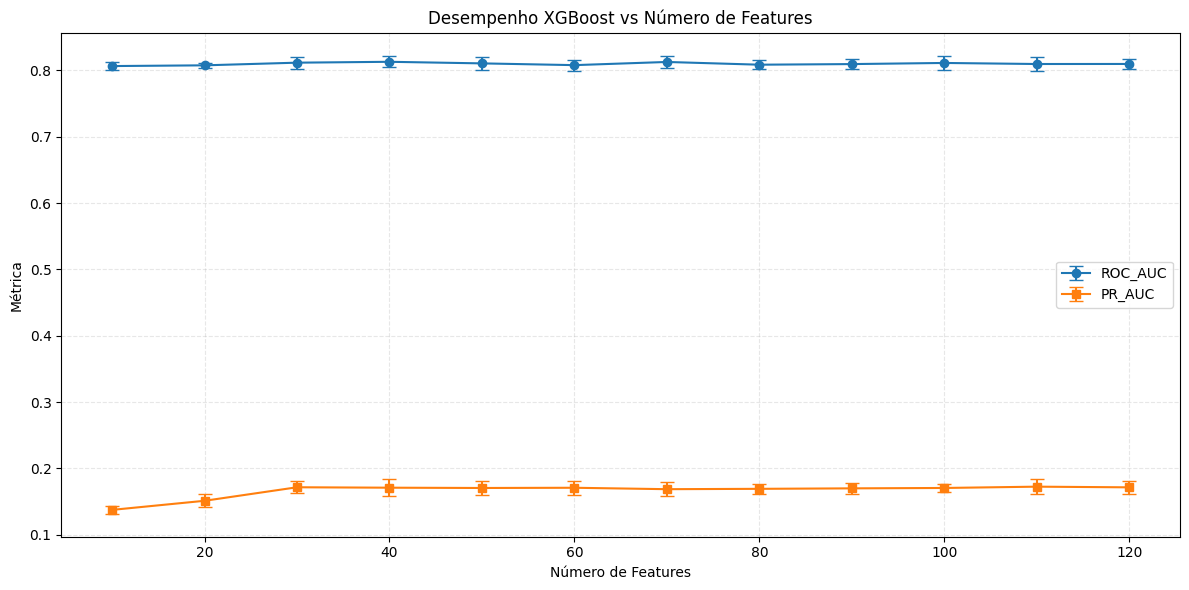

In [152]:
# Preparar os dados para o gráfico
resultados = []

for key, scores in score_modelos.items():
    n_features = int(key.split('_')[1])
    resultados.append({
        'n_features': n_features,
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'pr_auc_mean': scores['test_pr_auc'].mean(),
        'pr_auc_std': scores['test_pr_auc'].std()
    })

df_resultados = pd.DataFrame(resultados).sort_values('n_features')

# Plot
plt.figure(figsize=(12, 6))

# ROC_AUC
plt.errorbar(
    df_resultados['n_features'],
    df_resultados['roc_auc_mean'],
    yerr=df_resultados['roc_auc_std'],
    label='ROC_AUC',
    marker='o',
    capsize=5
)

# PR_AUC
plt.errorbar(
    df_resultados['n_features'],
    df_resultados['pr_auc_mean'],
    yerr=df_resultados['pr_auc_std'],
    label='PR_AUC',
    marker='s',
    capsize=5
)

plt.xlabel('Número de Features')
plt.ylabel('Métrica')
plt.title('Desempenho XGBoost vs Número de Features')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [153]:
df_resultados

,n_features,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,10,0.806585,0.006223,0.137562,0.005935
1,20,0.807686,0.003901,0.151271,0.009907
2,30,0.811699,0.009101,0.171654,0.009148
3,40,0.813023,0.008157,0.171007,0.012925
4,50,0.810630,0.010041,0.170570,0.010212
5,60,0.807988,0.008419,0.170901,0.010366
6,70,0.812765,0.009388,0.168756,0.010513
7,80,0.808647,0.007210,0.169295,0.007519
8,90,0.809573,0.008054,0.170004,0.008663
9,100,0.811271,0.010038,0.170596,0.006157


# Top 30 Features

In [273]:
# Modelo com as top 30 features
print("-" * 50)
n = 30
n_features = importancias[importancias["n_features"] <= n]
sel_features = n_features.index.tolist()
X_t30 = X_treino[sel_features]

print(f"Número de features considerado: {n}")

pipe_preprocessamento = Pipeline(
    [
        (
            "standard_scaling",
            PadronizaDados(sel_features)
        )
    ]
)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# Pipeline completo
pipeline_xgb_base = Pipeline(
    [
        (
            "preprocessing",
            pipe_preprocessamento,
        ),
        (
            "classifier",
            XGBClassifier(
                eval_metric="aucpr",
                objective="binary:logistic",
                random_state=42,
            ),
        ),
    ]
)

# Validação cruzada
scores = cross_validate(
    pipeline_xgb_base,
    X_treino[sel_features],
    y_treino,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)

print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")

# Fit do modelo
modelo_top_30 = pipeline_xgb_base["classifier"]
modelo_top_30.fit(X_treino[sel_features], y_treino)

# Importancias para o modelo
# Aumento médio da performance (mais informativo).
importancias_ganho = (
    modelo_top_30.get_booster()
    .get_score(importance_type="gain")
)

# Número de vezes que a feature foi usada em divisões.
importancias_peso = (
    modelo_top_30.get_booster()
    .get_score(importance_type="weight")
)

# Cobertura média (número de observações afetadas).
importancias_cobertura = (
    modelo_top_30.get_booster()
    .get_score(importance_type="cover")
)

importancias_t30 = pd.concat(
    [
        pd.Series(importancias_ganho, name="Ganho"),
        pd.Series(importancias_peso, name="Peso"),
        pd.Series(importancias_cobertura, name="Cobertura"),
    ],
    axis=1,
).fillna(0)

--------------------------------------------------
Número de features considerado: 30
ROC_AUC médio: 0.8117
PR_AUC médio : 0.1717


In [274]:
importancias_t30.sort_values(by='Ganho', ascending=False)

,Ganho,Peso,Cobertura
ind_var26_cte,15.159208,5.0,301.711914
saldo_var30,10.694338,221.0,471.885437
var15,7.794198,468.0,319.997925
ind_var30,4.726919,8.0,120.683586
num_var42_0,3.921058,35.0,960.401672
imp_op_var40_efect_ult3,3.499396,8.0,1580.542969
saldo_medio_var5_ult1,3.079785,146.0,268.960815
saldo_medio_var5_hace2,3.066774,208.0,277.233215
num_var22_ult1,2.990939,101.0,321.406494
saldo_medio_var5_hace3,2.768830,255.0,419.645782


## Análise Fatorial das Top 30 Features

Bartlett: chi2 = 1068688.02, p-value = 0.0000
Bartlett significativo: correlações suficientes para EFA.
KMO geral: 0.6762
KMO mediano


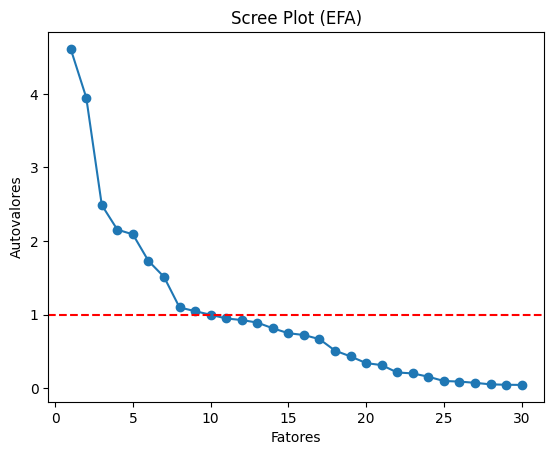

Número de fatores com autovalor > 1: 9


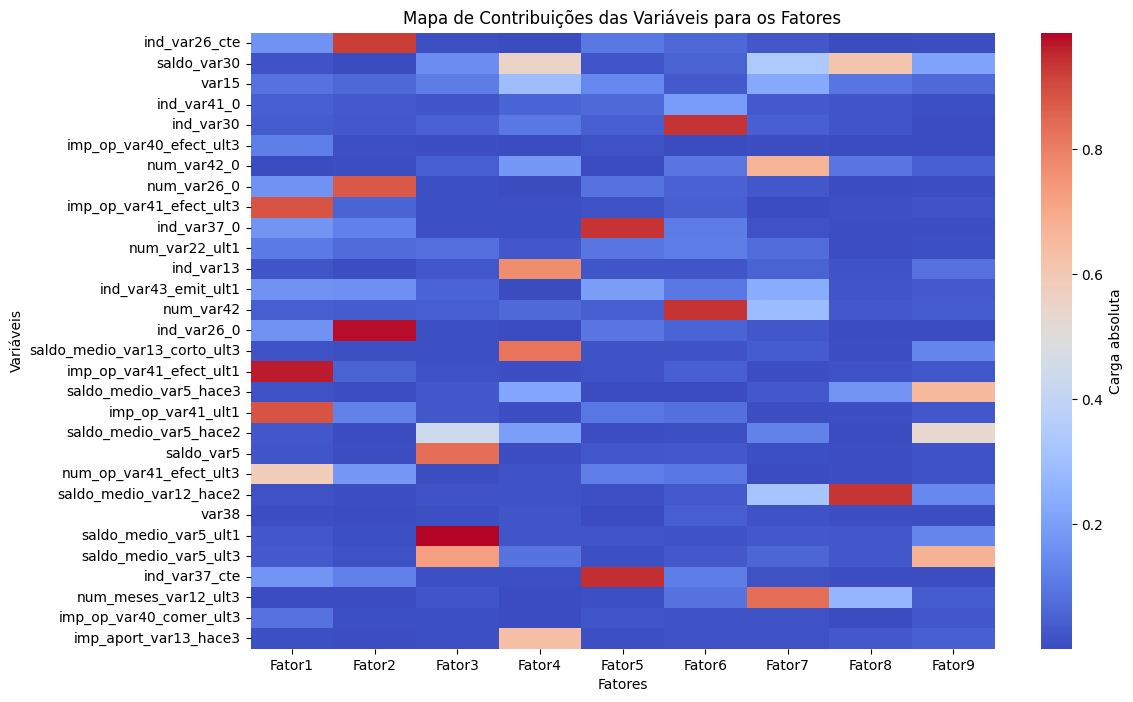

In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import (
    calculate_bartlett_sphericity,
    calculate_kmo,
)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_t30)

# Testes preliminares
# Teste de Esfericidade de Bartlett
chi2, p_value = calculate_bartlett_sphericity(X_t30)

print(f"Bartlett: chi2 = {chi2:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Bartlett significativo: correlações suficientes para EFA.")
else:
    print("Bartlett não significativo: EFA não é recomendada.")

# Medida de Adequação da Amostra (KMO)
kmo_all, kmo_model = calculate_kmo(X_t30)

print(f"KMO geral: {kmo_model:.4f}")

if kmo_model >= 0.8:
    print("KMO muito bom")
elif kmo_model >= 0.7:
    print("KMO bom")
elif kmo_model >= 0.6:
    print("KMO mediano")
elif kmo_model >= 0.5:
    print("KMO ruim (limite)")
else:
    print(" KMO inaceitável para EFA")

# Execução da Análise Fatorial
fa_test = FactorAnalyzer(rotation=None)
fa_test.fit(X_scaled)

# Extração de Autovalores
eigenvalues, _ = fa_test.get_eigenvalues()

# Plot do Gráfico de Autovalores
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(1, color='red', linestyle='--')
plt.xlabel("Fatores")
plt.ylabel("Autovalores")
plt.title("Scree Plot (EFA)")
plt.show()

# Número de fatores escolhidos segundo o critério de Kaiser
n_fatores = sum(eigenvalues > 1)
print(f"Número de fatores com autovalor > 1: {n_fatores}")

# Análise Fatorial c/ o número de fatores escolhidos e rotação varimax
# para maximar a interpretabilidade (talvez melhorar a definição)
fa = FactorAnalyzer(
    n_factors=n_fatores,
    rotation='varimax',
    method='ml'
)

# Treino
fa.fit(X_scaled)

# Obtenção das Cargas fatoriais
loadings = pd.DataFrame(
    fa.loadings_,
    index=X_t30.columns,
    columns=[f'Fator{i+1}' for i in range(n_fatores)]
)

# Obtenção das Comunalidades
communalities = pd.Series(
    fa.get_communalities(),
    index=X_t30.columns,
    name="Comunalidade"
)

# KMO individual por variável
kmo_all_df = pd.Series(
    kmo_all,
    index=X_t30.columns,
    name="KMO"
).sort_values(ascending=False)

# DataFrame utilizado para a escolha dos fatores
diagnostico_fatorial = pd.concat(
    [
        loadings,
        communalities,
        kmo_all_df
    ],
     axis=1
)

# Ordenação dos DataFrame
diagnostico_fatorial= diagnostico_fatorial .sort_values(
    by="Comunalidade",
    ascending=False
)

# Criação de uma coluna que indica a explicabilidade
diagnostico_fatorial["Nivel_explicabilidade"] = pd.cut(
    diagnostico_fatorial["Comunalidade"].clip(0, 1),
    bins=[0, 0.3, 0.5, 1],
    labels=["Baixa", "Media", "Alta"],
)

# Absoluto das cargas fatoriais para ver contribuições
abs_loadings = loadings.abs()

# Soma total por fator (quanto cada fator captura do dataset)
fator_contrib = abs_loadings.sum(axis=0).sort_values(ascending=False)

top_n = 5
top_vars_por_fator = {
    fator: abs_loadings[fator]
        .sort_values(ascending=False)
        .head(top_n).index.tolist()
    for fator in loadings.columns
}

plt.figure(figsize=(12, 8))
sns.heatmap(abs_loadings,
            cmap="coolwarm",
            cbar_kws=
                {
                    'label': 'Carga absoluta'
                }
)
plt.title("Mapa de Contribuições das Variáveis para os Fatores")
plt.xlabel("Fatores")
plt.ylabel("Variáveis")
plt.show()

- Bartlett's test of sphericity: Statistical test for the overall significance of all correlations within a correlation matrix. Used as a measure of sampling adequacy (MSA).
- Communality: The proportion of a variable's variance explained by the extracted factor structure. Final communality estimates are the sum of squared loadings for a variable in an orthogonal factor matrix.
- Eigen Value: Column sum of squared loadings for a factor. Represents the variance in the variables which is accounted for by a specific factor.
- Exploratory factor analysis: A factor analysis technique used to explore the underlying structure of a collection of observed variables.
- Extraction: The process for determining the number of factors to retain.
- Factor: Linear combination of the original variables. Factors represent the underlying dimensions (constructs) that summarise or account for the original set of observed variables.
- Factor analysis: A statistical technique used to estimate factors and/or reduce the dimensionality of a large number of variables to a fewer number of factors.
- Factor loading: Correlation between a variable and a factor, and the key to understanding the nature of a particular factor. Squared factor loadings indicate what percentage of the variance in an original variable is explained by a factor.
- Scree plot: A line graph of Eigen Values which is helpful for determining the number of factors. The Eigen Values are plotted in descending order. The number of factors is chosen where the plot levels off (or drops) from cliff to scree.
- Latent factor: A theoretical underlying factor hypothesised to influence a number of observed variables. Common factor analysis assumes latent variables are linearly related to observed variables

Fonte: https://en.wikiversity.org/wiki/Exploratory_factor_analysis/Glossary

### Fatores Criados

In [283]:
corte = 0.4
X_t30_fat = X_t30.copy()

In [ ]:
def cria_score_fatorial(df,
                        loadings_fatoriais,
                        nome_fator,
                        cut_off=0.4,
                        scaler=StandardScaler()):
    """
    Cria um Factor Score usando o método 'Sum Scores – Above a Cut-off Value'
    e adiciona diretamente ao DataFrame original.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame com os dados originais.
    loadings_fatoriais : pd.DataFrame
        DataFrame com as cargas fatoriais (linhas = variáveis, colunas = fatores).
    nome_fator : str
        Nome do fator a ser usado.
    cut_off : float, default=0.4
        Carga mínima para incluir a variável no cálculo do score.
    scaler : sklearn.preprocessing scaler, default=StandardScaler()
        Escalador para padronizar as variáveis antes da soma.

    Nota:
    -----
    Modifica o DataFrame original in-place. Não retorna nada.
    """

    # Seleciona variáveis com carga acima do cut-off
    mask_fator = loadings_fatoriais[nome_fator].abs() >= cut_off
    loadings_fator = loadings_fatoriais.loc[mask_fator, nome_fator]

    name_vars = loadings_fator.index.tolist()

    # Padroniza apenas as variáveis selecionadas
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[name_vars]),
        columns=name_vars,
        index=df.index
    )

    # Soma simples para criar o score
    factor_scores = df_scaled.sum(axis=1)

    # Adiciona o score ao DataFrame original
    df[f'{nome_fator}_score'] = factor_scores


#### Fator 1

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator1"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)

diagnostico_fator

,Fator1,Comunalidade,KMO,Nivel_explicabilidade
imp_op_var41_efect_ult1,0.964888,0.936901,0.717296,Alta
imp_op_var41_ult1,0.883231,0.813557,0.824369,Alta
imp_op_var41_efect_ult3,0.883898,0.787276,0.797526,Alta
num_op_var41_efect_ult3,0.585204,0.398764,0.888979,Media


"Factor loading: Correlation between a variable and a factor, and the key to understanding the nature of a particular factor. Squared factor loadings indicate what percentage of the variance in an original variable is explained by a factor. 
https://en.wikiversity.org/wiki/Exploratory_factor_analysis/Glossary

"Communality: The proportion of a variable's variance explained by the extracted factor structure. Final communality estimates are the sum of squared loadings for a variable in an orthogonal factor matrix." 
https://en.wikiversity.org/wiki/Exploratory_factor_analysis/Glossary

"The Kaiser–Meyer–Olkin (KMO) test is a statistical measure to determine how suited data is for factor analysis. The test measures sampling adequacy for each variable in the model and the complete model. The statistic is a measure of the proportion of variance among variables that might be common variance. The higher the proportion, the higher the KMO-value, the more suited the data is to factor analysis."
https://en.wikipedia.org/wiki/Kaiser%E2%80%93Meyer%E2%80%93Olkin_test

#### Fator 2

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator2"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)

diagnostico_fator

,Fator2,Comunalidade,KMO,Nivel_explicabilidade
ind_var26_0,0.977246,0.995006,0.701296,Alta
ind_var26_cte,0.924771,0.899512,0.770725,Alta
num_var26_0,0.877377,0.809360,0.864508,Alta


#### Fator 3

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator3"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)

diagnostico_fator

,Fator3,Comunalidade,KMO,Nivel_explicabilidade
saldo_medio_var5_ult3,0.727209,0.995033,0.578631,Alta
saldo_medio_var5_ult1,0.986950,0.995013,0.566735,Alta
saldo_var5,0.833235,0.696725,0.713151,Alta
saldo_medio_var5_hace2,0.436272,0.532892,0.652393,Alta


#### Fator 4

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator4"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)

diagnostico_fator

,Fator4,Comunalidade,KMO,Nivel_explicabilidade
saldo_var30,0.550962,0.868607,0.648084,Alta
saldo_medio_var13_corto_ult3,0.822801,0.697388,0.729922,Alta
ind_var13,0.770990,0.607077,0.695250,Alta
imp_aport_var13_hace3,0.637257,0.409485,0.714682,Media


#### Fator 5

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator5"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)

diagnostico_fator

,Fator5,Comunalidade,KMO,Nivel_explicabilidade
ind_var37_cte,0.948054,0.955992,0.618051,Alta
ind_var37_0,0.937746,0.936345,0.617661,Alta


#### Fator 6

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator6"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off= corte
)


diagnostico_fator

,Fator6,Comunalidade,KMO,Nivel_explicabilidade
num_var42,0.936876,0.974353,0.498560,Alta
ind_var30,0.938291,0.899966,0.472303,Alta


#### Fator 7

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator7"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= cut_off
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off=corte
)

diagnostico_fator

,Fator7,Comunalidade,KMO,Nivel_explicabilidade
num_meses_var12_ult3,0.833396,0.776069,0.690063,Alta
num_var42_0,0.670181,0.503108,0.768438,Alta


#### Fator 8

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator8"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >=corte
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off=corte
)

diagnostico_fator

,Fator8,Comunalidade,KMO,Nivel_explicabilidade
saldo_medio_var12_hace2,0.933516,0.995004,0.497285,Alta
saldo_var30,0.613647,0.868607,0.648084,Alta


#### Fator 9

In [ ]:
# Fator a ser analisado
fator_analisado = "Fator9"

# Colunas relevantes para o diagnóstico
colunas_analise = [
    fator_analisado,
    "Comunalidade",
    "KMO",
    "Nivel_explicabilidade",
]

# Máscara: variáveis com carga relevante no fator
mask_fator = (
    diagnostico_fatorial[fator_analisado]
    .abs()
    >= corte
)

# Diagnóstico do fator
diagnostico_fator = diagnostico_fatorial.loc[
    mask_fator,
    colunas_analise
]

# Adição dos Fatores
CriaScoreFatorial(
    X_t30_fat,
    diagnostico_fatorial,
    fator_analisado,
    cut_off=corte
)

diagnostico_fator

,Fator9,Comunalidade,KMO,Nivel_explicabilidade
saldo_medio_var5_ult3,0.671981,0.995033,0.578631,Alta
saldo_medio_var5_hace2,0.535350,0.532892,0.652393,Alta
saldo_medio_var5_hace3,0.654090,0.506849,0.463675,Alta


### Modelo com as top 30 Features + Fatores

In [248]:
# Modelo com as top 30 Features + Fatores
print("-" * 50)
features = X_t30_fat.columns.tolist()
print(f"Número de features considerado: {n}")

pipe_preprocessamento = Pipeline(
    [
        (
            "standard_scaling",
            PadronizaDados(features)
        )
    ]
)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# Pipeline completo
pipeline_xgb_base = Pipeline(
    [
        (
            "preprocessing",
            pipe_preprocessamento,
        ),
        (
            "classifier",
            XGBClassifier(
                eval_metric="aucpr",
                objective="binary:logistic",
                random_state=42,
            ),
        ),
    ]
)

# Validação cruzada
scores = cross_validate(
    pipeline_xgb_base,
    X_t30_fat,
    y_treino,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)

print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")

# Fit do modelo
modelo_top_30_fat = pipeline_xgb_base["classifier"]
modelo_top_30_fat.fit(X_t30_fat, y_treino)

# Importancias para o modelo
# Aumento médio da performance (mais informativo).
importancias_ganho = (
    modelo_top_30_fat.get_booster()
    .get_score(importance_type="gain")
)

# Número de vezes que a feature foi usada em divisões.
importancias_peso = (
    modelo_top_30_fat.get_booster()
    .get_score(importance_type="weight")
)

# Cobertura média (número de observações afetadas).
importancias_cobertura = (
    modelo_top_30_fat.get_booster()
    .get_score(importance_type="cover")
)

importancias_t30_fat = pd.concat(
    [
        pd.Series(importancias_ganho, name="Ganho"),
        pd.Series(importancias_peso, name="Peso"),
        pd.Series(importancias_cobertura, name="Cobertura"),
    ],
    axis=1,
).fillna(0)

--------------------------------------------------
Número de features considerado: 30
ROC_AUC médio: 0.8111
PR_AUC médio : 0.1739


In [254]:
importancias_t30_fat.sort_values(by="Ganho",ascending=False)

,Ganho,Peso,Cobertura
Fator8_score,27.061609,51.0,828.620850
ind_var26_cte,10.426547,8.0,214.008514
var15,7.997572,448.0,350.607758
saldo_var30,7.190287,119.0,322.334137
ind_var30,5.622683,8.0,114.395317
num_var42_0,4.299072,29.0,1002.561584
imp_op_var40_efect_ult3,3.664238,7.0,1653.604248
Fator4_score,3.478211,44.0,677.135742
Fator7_score,3.461696,8.0,726.737427
num_var42,3.372167,6.0,315.330170


### Modelos apenas com Fatores

In [313]:
# Modelo apenas Fatores
print("-" * 50)
fatores = [f'Fator{i}_score' for i in range(1, 10)]
features = X_t30_fat[fatores].columns.tolist()
n=len(features)
print(f"Número de features considerado: {n}")

pipe_preprocessamento = Pipeline(
    [
        (
            "standard_scaling",
            PadronizaDados(features)
        )
    ]
)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# Pipeline completo
pipeline_xgb_base = Pipeline(
    [
        (
            "preprocessing",
            pipe_preprocessamento,
        ),
        (
            "classifier",
            XGBClassifier(
                eval_metric="aucpr",
                objective="binary:logistic",
                random_state=42,
            ),
        ),
    ]
)

# Validação cruzada
scores = cross_validate(
    pipeline_xgb_base,
    X_t30_fat[features],
    y_treino,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)

print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")

# Fit do modelo
modelo_fat = pipeline_xgb_base["classifier"]
modelo_fat.fit(X_t30_fat[features], y_treino)

# Importancias para o modelo
# Aumento médio da performance (mais informativo).
importancias_ganho = (
    modelo_fat.get_booster()
    .get_score(importance_type="gain")
)

# Número de vezes que a feature foi usada em divisões.
importancias_peso = (
    modelo_fat.get_booster()
    .get_score(importance_type="weight")
)

# Cobertura média (número de observações afetadas).
importancias_cobertura = (
    modelo_fat.get_booster()
    .get_score(importance_type="cover")
)

importancias_fat = pd.concat(
    [
        pd.Series(importancias_ganho, name="Ganho"),
        pd.Series(importancias_peso, name="Peso"),
        pd.Series(importancias_cobertura, name="Cobertura"),
    ],
    axis=1,
).fillna(0)

--------------------------------------------------
Número de features considerado: 9
ROC_AUC médio: 0.7190
PR_AUC médio : 0.0870


In [314]:
importancias_fat

,Ganho,Peso,Cobertura
Fator1_score,1.980209,515.0,511.101562
Fator2_score,1.647741,72.0,602.473267
Fator3_score,1.780088,555.0,381.094238
Fator4_score,1.456484,385.0,430.934387
Fator5_score,1.967962,77.0,380.739746
Fator6_score,1.529713,28.0,250.485748
Fator7_score,1.534331,83.0,746.519836
Fator8_score,8.632395,295.0,687.955200
Fator9_score,1.648909,647.0,405.684845


# Modelo com Fatores e PCA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# ---- 1️⃣ Separar colunas ----
fatores_score = [f'Fator{i}_score' for i in range(1, 10)]
originais = [col for col in X_treino_fat.columns if col not in fatores_score]

# ---- 2️⃣ Escalar e aplicar PCA nas originais ----
scaler = StandardScaler()
X_orig_scaled = scaler.fit_transform(X_treino_fat[originais])

pca = PCA(n_components=n_componentes_kaiser)
X_orig_pca = pca.fit_transform(X_orig_scaled)

# Nomes dos componentes
pca_cols = [f'PCA_{i+1}' for i in range(n_componentes_kaiser)]

# ---- 3️⃣ Concatenar PCA + fatores ----
X_final = pd.DataFrame(
    data = np.hstack([X_orig_pca, X_treino_fat[fatores_score].values]),
    columns = pca_cols + fatores_score
)

# ---- 4️⃣ Treinar XGB ----
modelo_xgb = XGBClassifier(eval_metric='aucpr', objective='binary:logistic', random_state=42)
modelo_xgb.fit(X_final, y_treino)

# ---- 5️⃣ Importâncias ----
importancias_ganho = modelo_xgb.get_booster().get_score(importance_type='gain')
importancias_peso = modelo_xgb.get_booster().get_score(importance_type='weight')
importancias_cobertura = modelo_xgb.get_booster().get_score(importance_type='cover')

importancias_df = pd.DataFrame({
    'Ganho': pd.Series(importancias_ganho),
    'Peso': pd.Series(importancias_peso),
    'Cobertura': pd.Series(importancias_cobertura)
}).reindex(pca_cols + fatores_score).fillna(0)

importancias_df = importancias_df.sort_values('Ganho', ascending=False)

In [340]:
importancias_df.sort_values(by='Ganho', ascending=False).head(30)

,Ganho,Peso,Cobertura
PCA_19,31.075527,59.0,738.131104
Fator8_score,16.586664,37.0,623.275635
PCA_39,8.589347,58.0,349.803406
PCA_17,7.416318,72.0,274.899597
Fator4_score,6.668880,69.0,288.612701
PCA_59,6.356331,121.0,346.179504
PCA_55,5.763544,108.0,319.398895
Fator9_score,5.032928,111.0,394.840973
PCA_26,4.708571,51.0,239.624496
PCA_27,4.616335,49.0,207.743805


In [341]:
importancias_df.head(100)

,Ganho,Peso,Cobertura
PCA_19,31.075527,59.0,738.131104
Fator8_score,16.586664,37.0,623.275635
PCA_39,8.589347,58.0,349.803406
PCA_17,7.416318,72.0,274.899597
Fator4_score,6.668880,69.0,288.612701
...,...,...,...
PCA_9,2.182542,41.0,278.035095
PCA_4,2.141503,38.0,174.408630
PCA_6,1.992916,34.0,96.925697
Fator5_score,0.000000,0.0,0.000000
